In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:34 - loss: 0.1066 - STD: 1.9850e-04 - MAE: 0.3117

 3/64 [>.............................] - ETA: 1s - loss: 0.0447 - STD: 3.5574e-04 - MAE: 0.1664  

 6/64 [=>............................] - ETA: 1s - loss: 0.0341 - STD: 2.5865e-04 - MAE: 0.1430

 9/64 [===>..........................] - ETA: 1s - loss: 0.0322 - STD: 1.9259e-04 - MAE: 0.1409

12/64 [====>.........................] - ETA: 1s - loss: 0.0308 - STD: 1.5371e-04 - MAE: 0.1383

14/64 [=====>........................] - ETA: 3s - loss: 0.0301 - STD: 1.3673e-04 - MAE: 0.1352

17/64 [======>.......................] - ETA: 2s - loss: 0.0276 - STD: 1.2118e-04 - MAE: 0.1280

20/64 [========>.....................] - ETA: 2s - loss: 0.0250 - STD: 1.1332e-04 - MAE: 0.1204

23/64 [=========>....................] - ETA: 2s - loss: 0.0232 - STD: 1.0836e-04 - MAE: 0.1164

26/64 [===========>..................] - ETA: 1s - loss: 0.0220 - STD: 1.0361e-04 - MAE: 0.1144

29/64 [============>.................] - ETA: 1s - loss: 0.0208 - STD: 9.8779e-05 - MAE: 0.1116

32/64 [==============>...............] - ETA: 1s - loss: 0.0198 - STD: 9.4439e-05 - MAE: 0.1083

35/64 [===============>..............] - ETA: 1s - loss: 0.0190 - STD: 9.0760e-05 - MAE: 0.1056

38/64 [================>.............] - ETA: 1s - loss: 0.0183 - STD: 8.7833e-05 - MAE: 0.1033

41/64 [==================>...........] - ETA: 0s - loss: 0.0177 - STD: 8.5712e-05 - MAE: 0.1012

44/64 [===================>..........] - ETA: 0s - loss: 0.0172 - STD: 8.4272e-05 - MAE: 0.0996

47/64 [=====================>........] - ETA: 0s - loss: 0.0167 - STD: 8.3436e-05 - MAE: 0.0984

50/64 [======================>.......] - ETA: 0s - loss: 0.0163 - STD: 8.2996e-05 - MAE: 0.0974

53/64 [=======================>......] - ETA: 0s - loss: 0.0159 - STD: 8.2813e-05 - MAE: 0.0964

56/64 [=========================>....] - ETA: 0s - loss: 0.0156 - STD: 8.2842e-05 - MAE: 0.0954

59/64 [==========================>...] - ETA: 0s - loss: 0.0153 - STD: 8.3087e-05 - MAE: 0.0944

62/64 [============================>.] - ETA: 0s - loss: 0.0151 - STD: 8.3636e-05 - MAE: 0.0935

64/64 [==============================] - 4s 43ms/step - loss: 0.0149 - STD: 8.4166e-05 - MAE: 0.0930 - val_loss: 0.0094 - val_STD: 7.7798e-05 - val_MAE: 0.0763


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0100 - STD: 1.0546e-04 - MAE: 0.0780

 4/64 [>.............................] - ETA: 1s - loss: 0.0100 - STD: 1.0908e-04 - MAE: 0.0786

 7/64 [==>...........................] - ETA: 1s - loss: 0.0100 - STD: 1.1331e-04 - MAE: 0.0789

10/64 [===>..........................] - ETA: 1s - loss: 0.0100 - STD: 1.1753e-04 - MAE: 0.0788

13/64 [=====>........................] - ETA: 1s - loss: 0.0099 - STD: 1.2146e-04 - MAE: 0.0785

16/64 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 1.2552e-04 - MAE: 0.0783

19/64 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 1.2999e-04 - MAE: 0.0781

22/64 [=========>....................] - ETA: 0s - loss: 0.0099 - STD: 1.3494e-04 - MAE: 0.0781

25/64 [==========>...................] - ETA: 0s - loss: 0.0099 - STD: 1.4015e-04 - MAE: 0.0781

28/64 [============>.................] - ETA: 0s - loss: 0.0099 - STD: 1.4561e-04 - MAE: 0.0780

31/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 1.5139e-04 - MAE: 0.0780

34/64 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 1.5757e-04 - MAE: 0.0779

37/64 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 1.6400e-04 - MAE: 0.0779

40/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 1.7095e-04 - MAE: 0.0779

43/64 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 1.7850e-04 - MAE: 0.0779

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 1.8657e-04 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.9517e-04 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.0437e-04 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.1427e-04 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.2488e-04 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.3648e-04 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 2.4926e-04 - MAE: 0.0779

64/64 [==============================] - 2s 26ms/step - loss: 0.0099 - STD: 2.4926e-04 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 3.9003e-04 - val_MAE: 0.0765


Epoch 3/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0096 - STD: 5.4266e-04 - MAE: 0.0772

 4/64 [>.............................] - ETA: 1s - loss: 0.0098 - STD: 5.6779e-04 - MAE: 0.0775

 7/64 [==>...........................] - ETA: 1s - loss: 0.0099 - STD: 5.9567e-04 - MAE: 0.0776

10/64 [===>..........................] - ETA: 1s - loss: 0.0099 - STD: 6.2768e-04 - MAE: 0.0777

13/64 [=====>........................] - ETA: 1s - loss: 0.0098 - STD: 6.6344e-04 - MAE: 0.0776

16/64 [======>.......................] - ETA: 1s - loss: 0.0098 - STD: 7.0177e-04 - MAE: 0.0776

19/64 [=======>......................] - ETA: 1s - loss: 0.0098 - STD: 7.4576e-04 - MAE: 0.0777

22/64 [=========>....................] - ETA: 0s - loss: 0.0098 - STD: 7.9384e-04 - MAE: 0.0777

25/64 [==========>...................] - ETA: 0s - loss: 0.0098 - STD: 8.4837e-04 - MAE: 0.0776

28/64 [============>.................] - ETA: 0s - loss: 0.0098 - STD: 9.0793e-04 - MAE: 0.0775

31/64 [=============>................] - ETA: 0s - loss: 0.0098 - STD: 9.7614e-04 - MAE: 0.0776

34/64 [==============>...............] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776    

37/64 [================>.............] - ETA: 0s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776

40/64 [=================>............] - ETA: 0s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0776

43/64 [===================>..........] - ETA: 0s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0776

46/64 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0775

49/64 [=====================>........] - ETA: 0s - loss: 0.0098 - STD: 0.0016 - MAE: 0.0775

52/64 [=======================>......] - ETA: 0s - loss: 0.0098 - STD: 0.0018 - MAE: 0.0775

54/64 [========================>.....] - ETA: 0s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0774

57/64 [=========================>....] - ETA: 0s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0774

60/64 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0024 - MAE: 0.0773

63/64 [============================>.] - ETA: 0s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0772

64/64 [==============================] - 2s 26ms/step - loss: 0.0097 - STD: 0.0028 - MAE: 0.0771 - val_loss: 0.0086 - val_STD: 0.0073 - val_MAE: 0.0733


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0092 - STD: 0.0104 - MAE: 0.0749

 4/64 [>.............................] - ETA: 1s - loss: 0.0090 - STD: 0.0114 - MAE: 0.0746

 7/64 [==>...........................] - ETA: 1s - loss: 0.0089 - STD: 0.0124 - MAE: 0.0742

10/64 [===>..........................] - ETA: 1s - loss: 0.0088 - STD: 0.0136 - MAE: 0.0739

13/64 [=====>........................] - ETA: 1s - loss: 0.0088 - STD: 0.0148 - MAE: 0.0738

16/64 [======>.......................] - ETA: 1s - loss: 0.0087 - STD: 0.0162 - MAE: 0.0735

19/64 [=======>......................] - ETA: 1s - loss: 0.0087 - STD: 0.0176 - MAE: 0.0733

22/64 [=========>....................] - ETA: 0s - loss: 0.0086 - STD: 0.0190 - MAE: 0.0729

25/64 [==========>...................] - ETA: 0s - loss: 0.0085 - STD: 0.0204 - MAE: 0.0726

28/64 [============>.................] - ETA: 0s - loss: 0.0085 - STD: 0.0218 - MAE: 0.0723

31/64 [=============>................] - ETA: 0s - loss: 0.0084 - STD: 0.0231 - MAE: 0.0719

34/64 [==============>...............] - ETA: 0s - loss: 0.0084 - STD: 0.0244 - MAE: 0.0716

37/64 [================>.............] - ETA: 0s - loss: 0.0083 - STD: 0.0256 - MAE: 0.0713

40/64 [=================>............] - ETA: 0s - loss: 0.0083 - STD: 0.0267 - MAE: 0.0710

43/64 [===================>..........] - ETA: 0s - loss: 0.0082 - STD: 0.0278 - MAE: 0.0708

46/64 [====================>.........] - ETA: 0s - loss: 0.0082 - STD: 0.0288 - MAE: 0.0705

49/64 [=====================>........] - ETA: 0s - loss: 0.0081 - STD: 0.0298 - MAE: 0.0702

52/64 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0306 - MAE: 0.0699

55/64 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.0315 - MAE: 0.0696

58/64 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0323 - MAE: 0.0692

61/64 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.0331 - MAE: 0.0689

64/64 [==============================] - ETA: 0s - loss: 0.0078 - STD: 0.0339 - MAE: 0.0686

64/64 [==============================] - 2s 26ms/step - loss: 0.0078 - STD: 0.0339 - MAE: 0.0686 - val_loss: 0.0057 - val_STD: 0.0416 - val_MAE: 0.0596


Epoch 5/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0521 - MAE: 0.0627

 4/64 [>.............................] - ETA: 1s - loss: 0.0065 - STD: 0.0523 - MAE: 0.0619

 7/64 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0528 - MAE: 0.0611

10/64 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0608

13/64 [=====>........................] - ETA: 1s - loss: 0.0062 - STD: 0.0540 - MAE: 0.0605

16/64 [======>.......................] - ETA: 1s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0602

19/64 [=======>......................] - ETA: 1s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0599

22/64 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0554 - MAE: 0.0597

25/64 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0595

28/64 [============>.................] - ETA: 0s - loss: 0.0060 - STD: 0.0564 - MAE: 0.0594

31/64 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0570 - MAE: 0.0592

34/64 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0575 - MAE: 0.0590

37/64 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0579 - MAE: 0.0588

40/64 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0583 - MAE: 0.0587

43/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0586 - MAE: 0.0585

46/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0588 - MAE: 0.0584

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0590 - MAE: 0.0583

52/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0593 - MAE: 0.0582

55/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0595 - MAE: 0.0582

58/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0597 - MAE: 0.0581

61/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0598 - MAE: 0.0580

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0600 - MAE: 0.0580

64/64 [==============================] - 2s 26ms/step - loss: 0.0058 - STD: 0.0600 - MAE: 0.0580 - val_loss: 0.0047 - val_STD: 0.0567 - val_MAE: 0.0536


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0556

 4/64 [>.............................] - ETA: 1s - loss: 0.0056 - STD: 0.0640 - MAE: 0.0565

 7/64 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0635 - MAE: 0.0564

10/64 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0632 - MAE: 0.0562

13/64 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0633 - MAE: 0.0563

16/64 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0634 - MAE: 0.0564

19/64 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0563

22/64 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0562

25/64 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0636 - MAE: 0.0561

28/64 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0638 - MAE: 0.0561

31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0638 - MAE: 0.0561

34/64 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0639 - MAE: 0.0560

37/64 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0639 - MAE: 0.0560

40/64 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0640 - MAE: 0.0560

43/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0641 - MAE: 0.0559

46/64 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0642 - MAE: 0.0559

49/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0643 - MAE: 0.0558

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0558

55/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0558

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0644 - MAE: 0.0558

61/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0645 - MAE: 0.0557

64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0646 - MAE: 0.0557

64/64 [==============================] - 2s 26ms/step - loss: 0.0054 - STD: 0.0646 - MAE: 0.0557 - val_loss: 0.0045 - val_STD: 0.0586 - val_MAE: 0.0519


Epoch 7/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0548

 4/64 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0551

 7/64 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0550

10/64 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0655 - MAE: 0.0549

13/64 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0656 - MAE: 0.0549

16/64 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0548

19/64 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0549

22/64 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0548

25/64 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0659 - MAE: 0.0548

28/64 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0660 - MAE: 0.0548

31/64 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0547

34/64 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0547

37/64 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0547

40/64 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0547

43/64 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0547

46/64 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0661 - MAE: 0.0547

49/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0547

52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0547

55/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0546

58/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0546

61/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0546

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0546

64/64 [==============================] - 2s 26ms/step - loss: 0.0052 - STD: 0.0663 - MAE: 0.0546 - val_loss: 0.0046 - val_STD: 0.0643 - val_MAE: 0.0530


Epoch 8/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0723 - MAE: 0.0556

 4/64 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0689 - MAE: 0.0544

 7/64 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0541

10/64 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0544

13/64 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0544

16/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0545

19/64 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0543

22/64 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0543

25/64 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0542

28/64 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0541

31/64 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0541

34/64 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0541

37/64 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0541

40/64 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0541

43/64 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0541

46/64 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0541

49/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0541

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0540

55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0540

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0540

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0540

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0539

64/64 [==============================] - 2s 26ms/step - loss: 0.0051 - STD: 0.0676 - MAE: 0.0539 - val_loss: 0.0045 - val_STD: 0.0632 - val_MAE: 0.0524


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0719 - MAE: 0.0552

 4/64 [>.............................] - ETA: 1s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0539

 7/64 [==>...........................] - ETA: 1s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0538

10/64 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0537

13/64 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0536

16/64 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0534

18/64 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0535

20/64 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0534

23/64 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0534

26/64 [===========>..................] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0533

29/64 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0533

32/64 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0532

35/64 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0531

38/64 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0531

41/64 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0531

44/64 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0530

47/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0530

50/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0531

53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0530

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0530

59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0530

62/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0530

64/64 [==============================] - 2s 27ms/step - loss: 0.0050 - STD: 0.0690 - MAE: 0.0530 - val_loss: 0.0043 - val_STD: 0.0583 - val_MAE: 0.0495


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0531

 4/64 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0524

 7/64 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0524

10/64 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0527

12/64 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0525

15/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0525

18/64 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0526

21/64 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0526

24/64 [==========>...................] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0526

27/64 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0525

30/64 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0525

33/64 [==============>...............] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0524

36/64 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0525

39/64 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0526

42/64 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0526

45/64 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0527

48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0528

51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0530

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0531

57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0531

60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0531

63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0531

64/64 [==============================] - 2s 26ms/step - loss: 0.0050 - STD: 0.0687 - MAE: 0.0531 - val_loss: 0.0044 - val_STD: 0.0656 - val_MAE: 0.0520


Epoch 11/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0750 - MAE: 0.0546

 4/64 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0530

 7/64 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0529

10/64 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0529

13/64 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0527

16/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0524

19/64 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0523

22/64 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0522

25/64 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0521

28/64 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0521

31/64 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0520

33/64 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0520

36/64 [===============>..............] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0520

39/64 [=================>............] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0519

42/64 [==================>...........] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0519

45/64 [====================>.........] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0519

48/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0518

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0518

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0518

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0518

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0518

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0518

64/64 [==============================] - 2s 26ms/step - loss: 0.0048 - STD: 0.0705 - MAE: 0.0518 - val_loss: 0.0043 - val_STD: 0.0657 - val_MAE: 0.0507


Epoch 12/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0048 - STD: 0.0740 - MAE: 0.0527

 4/64 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0518

 7/64 [==>...........................] - ETA: 1s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0516

10/64 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0515

13/64 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0514

16/64 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0512

19/64 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0513

22/64 [=========>....................] - ETA: 0s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0513

25/64 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0513

28/64 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0513

30/64 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0512

33/64 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0512

36/64 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0512

39/64 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0511

42/64 [==================>...........] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0511

45/64 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0511

48/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0511

51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0511

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0511

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0512

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0512

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0512

64/64 [==============================] - 2s 26ms/step - loss: 0.0047 - STD: 0.0712 - MAE: 0.0513 - val_loss: 0.0045 - val_STD: 0.0545 - val_MAE: 0.0494


Epoch 13/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0050 - STD: 0.0627 - MAE: 0.0507

 4/64 [>.............................] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0519

 7/64 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0518

10/64 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0524

13/64 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0689 - MAE: 0.0534

16/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0540

19/64 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0540

22/64 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0536

25/64 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535

28/64 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0534

31/64 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0533

34/64 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0531

37/64 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0530

40/64 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0528

43/64 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0527

46/64 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0526

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0524

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0522

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0521

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0521

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0520

64/64 [==============================] - 2s 26ms/step - loss: 0.0048 - STD: 0.0699 - MAE: 0.0520 - val_loss: 0.0041 - val_STD: 0.0613 - val_MAE: 0.0481


Epoch 14/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0695 - MAE: 0.0495

 4/64 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0502

 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0503

10/64 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0503

13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0502

16/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0502

19/64 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0502

22/64 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0502

25/64 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0502

28/64 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502

31/64 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0501

34/64 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0502

37/64 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0503

40/64 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0504

43/64 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0506

46/64 [====================>.........] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0508

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0508

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0508

55/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0508

57/64 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0509

59/64 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0508

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0714 - MAE: 0.0508

64/64 [==============================] - 2s 26ms/step - loss: 0.0046 - STD: 0.0715 - MAE: 0.0508 - val_loss: 0.0039 - val_STD: 0.0615 - val_MAE: 0.0475


Epoch 15/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0498

 4/64 [>.............................] - ETA: 1s - loss: 0.0046 - STD: 0.0727 - MAE: 0.0501

 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0500

10/64 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0502

13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501

16/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501

19/64 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0501

22/64 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0501

25/64 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0502

28/64 [============>.................] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0502

31/64 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0501

34/64 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0501

37/64 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0501

40/64 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

43/64 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

46/64 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0500

52/64 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

55/64 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

58/64 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0499

61/64 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0499

64/64 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0499

64/64 [==============================] - 2s 26ms/step - loss: 0.0045 - STD: 0.0726 - MAE: 0.0499 - val_loss: 0.0040 - val_STD: 0.0617 - val_MAE: 0.0476


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0044 - STD: 0.0708 - MAE: 0.0487

 4/64 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0492

 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0494

10/64 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

16/64 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

19/64 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

22/64 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0495

25/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

28/64 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0495

31/64 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

34/64 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

37/64 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0495

40/64 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0494

43/64 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0494

46/64 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0494

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0493

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0493

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493

64/64 [==============================] - 2s 26ms/step - loss: 0.0044 - STD: 0.0733 - MAE: 0.0493 - val_loss: 0.0039 - val_STD: 0.0629 - val_MAE: 0.0469


Epoch 17/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0478

 4/64 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0738 - MAE: 0.0496

 7/64 [==>...........................] - ETA: 1s - loss: 0.0045 - STD: 0.0740 - MAE: 0.0501

10/64 [===>..........................] - ETA: 1s - loss: 0.0046 - STD: 0.0732 - MAE: 0.0503

13/64 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0500

16/64 [======>.......................] - ETA: 1s - loss: 0.0045 - STD: 0.0732 - MAE: 0.0499

19/64 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0730 - MAE: 0.0499

22/64 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0500

25/64 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0725 - MAE: 0.0503

28/64 [============>.................] - ETA: 0s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0509

31/64 [=============>................] - ETA: 0s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0515

34/64 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0517

37/64 [================>.............] - ETA: 0s - loss: 0.0048 - STD: 0.0706 - MAE: 0.0517

40/64 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0518

43/64 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0519

46/64 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0520

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0519

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0519

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0519

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0517

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0517

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0516

64/64 [==============================] - 2s 26ms/step - loss: 0.0048 - STD: 0.0703 - MAE: 0.0516 - val_loss: 0.0039 - val_STD: 0.0608 - val_MAE: 0.0468


Epoch 18/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0045 - STD: 0.0699 - MAE: 0.0497

 3/64 [>.............................] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0494

 6/64 [=>............................] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0494

 9/64 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0495

12/64 [====>.........................] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0494

15/64 [======>.......................] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0493

18/64 [=======>......................] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0493

21/64 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493

24/64 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0493

27/64 [===========>..................] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

30/64 [=============>................] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492

33/64 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491

36/64 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491

39/64 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0491

42/64 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0490

45/64 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0490

48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489

64/64 [==============================] - 2s 27ms/step - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488 - val_loss: 0.0038 - val_STD: 0.0666 - val_MAE: 0.0470


Epoch 19/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0043 - STD: 0.0759 - MAE: 0.0486

 4/64 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0751 - MAE: 0.0485

 7/64 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0749 - MAE: 0.0485

10/64 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484

13/64 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0484

16/64 [======>.......................] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0485

19/64 [=======>......................] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

22/64 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0484

25/64 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0483

28/64 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483

31/64 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0483

34/64 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0483

37/64 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0483

40/64 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0484

43/64 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0483

46/64 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0483

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0484

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0486

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0490

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492

64/64 [==============================] - 2s 26ms/step - loss: 0.0044 - STD: 0.0737 - MAE: 0.0492 - val_loss: 0.0047 - val_STD: 0.0513 - val_MAE: 0.0498


Epoch 20/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0505

 4/64 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0507

 7/64 [==>...........................] - ETA: 1s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0512

10/64 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0508

13/64 [=====>........................] - ETA: 1s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0510

16/64 [======>.......................] - ETA: 1s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0508

19/64 [=======>......................] - ETA: 1s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0506

22/64 [=========>....................] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0503

25/64 [==========>...................] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0501

28/64 [============>.................] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0500

31/64 [=============>................] - ETA: 0s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

34/64 [==============>...............] - ETA: 0s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0497

37/64 [================>.............] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0496

40/64 [=================>............] - ETA: 0s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0495

43/64 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0494

46/64 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0493

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0492

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0490

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0490

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0489

64/64 [==============================] - 2s 26ms/step - loss: 0.0044 - STD: 0.0730 - MAE: 0.0489 - val_loss: 0.0038 - val_STD: 0.0644 - val_MAE: 0.0463


Epoch 21/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0477

 4/64 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

 7/64 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0478

10/64 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0478

13/64 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

16/64 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

19/64 [=======>......................] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

22/64 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

25/64 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

28/64 [============>.................] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

31/64 [=============>................] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

34/64 [==============>...............] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

37/64 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

40/64 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

43/64 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

46/64 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0476

64/64 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0752 - MAE: 0.0476 - val_loss: 0.0038 - val_STD: 0.0638 - val_MAE: 0.0459


Epoch 22/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0476

 4/64 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

 6/64 [=>............................] - ETA: 1s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0475

 9/64 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0475

12/64 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

15/64 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0475

18/64 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0475

21/64 [========>.....................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0475

24/64 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

27/64 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

30/64 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

33/64 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

36/64 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

39/64 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

42/64 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

45/64 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

64/64 [==============================] - 2s 26ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475 - val_loss: 0.0039 - val_STD: 0.0616 - val_MAE: 0.0458


Epoch 23/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0468

 4/64 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0745 - MAE: 0.0469

 7/64 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0470

10/64 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

13/64 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

16/64 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

19/64 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

22/64 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

25/64 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

28/64 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

31/64 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

34/64 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

37/64 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

40/64 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

43/64 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

46/64 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

64/64 [==============================] - 2s 26ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473 - val_loss: 0.0042 - val_STD: 0.0738 - val_MAE: 0.0497


Epoch 24/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0841 - MAE: 0.0514

 4/64 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0758 - MAE: 0.0492

 7/64 [==>...........................] - ETA: 1s - loss: 0.0043 - STD: 0.0748 - MAE: 0.0484

10/64 [===>..........................] - ETA: 1s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0483

13/64 [=====>........................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480

16/64 [======>.......................] - ETA: 1s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479

19/64 [=======>......................] - ETA: 1s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0478

22/64 [=========>....................] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0477

25/64 [==========>...................] - ETA: 0s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

28/64 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

31/64 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

34/64 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

37/64 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

40/64 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

43/64 [===================>..........] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0476

46/64 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0476

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0754 - MAE: 0.0476

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0476

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

64/64 [==============================] - 2s 26ms/step - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476 - val_loss: 0.0037 - val_STD: 0.0681 - val_MAE: 0.0459


Epoch 25/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0044 - STD: 0.0787 - MAE: 0.0492

 3/64 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0760 - MAE: 0.0477

 5/64 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

 8/64 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

11/64 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

14/64 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

17/64 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

20/64 [========>.....................] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

23/64 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

25/64 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

28/64 [============>.................] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

31/64 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

34/64 [==============>...............] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

37/64 [================>.............] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

40/64 [=================>............] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

43/64 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

46/64 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

64/64 [==============================] - 2s 27ms/step - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470 - val_loss: 0.0037 - val_STD: 0.0650 - val_MAE: 0.0448


Epoch 26/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0041 - STD: 0.0738 - MAE: 0.0461

 4/64 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0466

 7/64 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466

10/64 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

13/64 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

16/64 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

19/64 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

22/64 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

25/64 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

28/64 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

31/64 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

34/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

37/64 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

40/64 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

43/64 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

46/64 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

64/64 [==============================] - 2s 26ms/step - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467 - val_loss: 0.0039 - val_STD: 0.0722 - val_MAE: 0.0477


Epoch 27/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0820 - MAE: 0.0494

 4/64 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0477

 7/64 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0477

10/64 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

13/64 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

16/64 [======>.......................] - ETA: 1s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

19/64 [=======>......................] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

22/64 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

25/64 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0469

28/64 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

31/64 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

34/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469

37/64 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

40/64 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

43/64 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0470

46/64 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

64/64 [==============================] - 2s 26ms/step - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471 - val_loss: 0.0036 - val_STD: 0.0673 - val_MAE: 0.0444


Epoch 28/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0447

 4/64 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

10/64 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

13/64 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0463

16/64 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

19/64 [=======>......................] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0463

22/64 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462

25/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

28/64 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461

31/64 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

34/64 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

37/64 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

40/64 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

43/64 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

46/64 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

64/64 [==============================] - 2s 26ms/step - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466 - val_loss: 0.0039 - val_STD: 0.0720 - val_MAE: 0.0478


Epoch 29/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0808 - MAE: 0.0499

 4/64 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0491

 7/64 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0755 - MAE: 0.0493

10/64 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0743 - MAE: 0.0511

13/64 [=====>........................] - ETA: 1s - loss: 0.0050 - STD: 0.0714 - MAE: 0.0524

16/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0707 - MAE: 0.0519

19/64 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0713 - MAE: 0.0519

22/64 [=========>....................] - ETA: 0s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0519

25/64 [==========>...................] - ETA: 0s - loss: 0.0048 - STD: 0.0710 - MAE: 0.0517

28/64 [============>.................] - ETA: 0s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0513

31/64 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0510

34/64 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0715 - MAE: 0.0508

37/64 [================>.............] - ETA: 0s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0505

40/64 [=================>............] - ETA: 0s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0502

43/64 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0500

46/64 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0496

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0492

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0489

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0488

64/64 [==============================] - 2s 27ms/step - loss: 0.0044 - STD: 0.0733 - MAE: 0.0488 - val_loss: 0.0036 - val_STD: 0.0671 - val_MAE: 0.0447


Epoch 30/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0459

 4/64 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0461

 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

13/64 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

16/64 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

19/64 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

22/64 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

25/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

28/64 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

31/64 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

34/64 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

37/64 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

40/64 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

43/64 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

46/64 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

64/64 [==============================] - 2s 26ms/step - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459 - val_loss: 0.0036 - val_STD: 0.0661 - val_MAE: 0.0443


Epoch 31/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0449

 3/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0455

 6/64 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

 9/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0457

12/64 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0457

15/64 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0457

18/64 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

21/64 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

24/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

27/64 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

30/64 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

33/64 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

36/64 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

39/64 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0460

42/64 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

45/64 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

64/64 [==============================] - 2s 26ms/step - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459 - val_loss: 0.0035 - val_STD: 0.0697 - val_MAE: 0.0446


Epoch 32/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0465

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0459

10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

13/64 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

16/64 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0456

22/64 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0456

25/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

28/64 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

31/64 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

34/64 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

37/64 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

40/64 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0456

43/64 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

46/64 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0456

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

64/64 [==============================] - 2s 26ms/step - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457 - val_loss: 0.0037 - val_STD: 0.0727 - val_MAE: 0.0464


Epoch 33/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0828 - MAE: 0.0490

 4/64 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0796 - MAE: 0.0463

 7/64 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0464

10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0462

13/64 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459

16/64 [======>.......................] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

19/64 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

22/64 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0457

25/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0456

28/64 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0456

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0456

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0456

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

64/64 [==============================] - 2s 26ms/step - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455 - val_loss: 0.0035 - val_STD: 0.0684 - val_MAE: 0.0438


Epoch 34/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0443

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

22/64 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0456

25/64 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

28/64 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0461

31/64 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0463

34/64 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0463

37/64 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0463

40/64 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

43/64 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

46/64 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0461

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0460

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

64/64 [==============================] - 2s 26ms/step - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459 - val_loss: 0.0037 - val_STD: 0.0650 - val_MAE: 0.0446


Epoch 35/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0454

 4/64 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459

10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

22/64 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

25/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

64/64 [==============================] - 2s 26ms/step - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454 - val_loss: 0.0034 - val_STD: 0.0705 - val_MAE: 0.0436


Epoch 36/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446

 4/64 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

 7/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

22/64 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

25/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

64/64 [==============================] - 2s 26ms/step - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454 - val_loss: 0.0034 - val_STD: 0.0695 - val_MAE: 0.0433


Epoch 37/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0448

 4/64 [>.............................] - ETA: 1s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0459

 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0463

10/64 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0460

13/64 [=====>........................] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0456

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

19/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

22/64 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

25/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0451

28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

46/64 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

64/64 [==============================] - 2s 26ms/step - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453 - val_loss: 0.0034 - val_STD: 0.0695 - val_MAE: 0.0433


Epoch 38/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0774 - MAE: 0.0436

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

12/64 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

15/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

18/64 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

21/64 [========>.....................] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

24/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

27/64 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

30/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

33/64 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

36/64 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

38/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

41/64 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

44/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

64/64 [==============================] - 2s 26ms/step - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453 - val_loss: 0.0034 - val_STD: 0.0701 - val_MAE: 0.0431


Epoch 39/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0778 - MAE: 0.0433

 4/64 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

19/64 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

22/64 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

34/64 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

37/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

40/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

64/64 [==============================] - 2s 25ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446 - val_loss: 0.0034 - val_STD: 0.0694 - val_MAE: 0.0432


Epoch 40/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0769 - MAE: 0.0440

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0448

 7/64 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0785 - MAE: 0.0457

10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0452

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451

19/64 [=======>......................] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

22/64 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0450

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0450

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0449

40/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

64/64 [==============================] - 2s 26ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448 - val_loss: 0.0034 - val_STD: 0.0723 - val_MAE: 0.0430


Epoch 41/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0810 - MAE: 0.0443

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0802 - MAE: 0.0446

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

19/64 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

22/64 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

25/64 [==========>...................] - ETA: 0s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0449

28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0450

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

37/64 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

40/64 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

43/64 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

64/64 [==============================] - 2s 26ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447 - val_loss: 0.0036 - val_STD: 0.0755 - val_MAE: 0.0451


Epoch 42/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0839 - MAE: 0.0465

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0449

10/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0450

13/64 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0450

16/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0449

19/64 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

22/64 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

34/64 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

37/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

40/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

64/64 [==============================] - 2s 26ms/step - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445 - val_loss: 0.0034 - val_STD: 0.0729 - val_MAE: 0.0430


Epoch 43/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0814 - MAE: 0.0438

 4/64 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0440

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0442

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0443

13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0445

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

19/64 [=======>......................] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

22/64 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

34/64 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

37/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

40/64 [=================>............] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

46/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

64/64 [==============================] - 2s 26ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445 - val_loss: 0.0036 - val_STD: 0.0772 - val_MAE: 0.0449


Epoch 44/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0852 - MAE: 0.0466

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448

 7/64 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0443

10/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442

13/64 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

16/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0443

19/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443

22/64 [=========>....................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

28/64 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

31/64 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

34/64 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

37/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

40/64 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

43/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

45/64 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

64/64 [==============================] - 2s 26ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445 - val_loss: 0.0034 - val_STD: 0.0737 - val_MAE: 0.0438


Epoch 45/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0822 - MAE: 0.0452

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

19/64 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

22/64 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

28/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

31/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

34/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

37/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

40/64 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

43/64 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

46/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

64/64 [==============================] - 2s 26ms/step - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441 - val_loss: 0.0034 - val_STD: 0.0705 - val_MAE: 0.0428


Epoch 46/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0788 - MAE: 0.0433

 3/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0444

 6/64 [=>............................] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0457

 9/64 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454

12/64 [====>.........................] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453

15/64 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

18/64 [=======>......................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

20/64 [========>.....................] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

23/64 [=========>....................] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

26/64 [===========>..................] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

29/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

32/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

35/64 [===============>..............] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

38/64 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

41/64 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

44/64 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

64/64 [==============================] - 2s 26ms/step - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445 - val_loss: 0.0034 - val_STD: 0.0688 - val_MAE: 0.0431


Epoch 47/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0430

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0439

 7/64 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0441

10/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0439

13/64 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

16/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

19/64 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

22/64 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0447

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

28/64 [============>.................] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0448

31/64 [=============>................] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

34/64 [==============>...............] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

37/64 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

40/64 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0464

43/64 [===================>..........] - ETA: 0s - loss: 0.0041 - STD: 0.0772 - MAE: 0.0466

46/64 [====================>.........] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0468

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0468

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

64/64 [==============================] - 2s 26ms/step - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465 - val_loss: 0.0035 - val_STD: 0.0707 - val_MAE: 0.0452


Epoch 48/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0465

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

 7/64 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0451

10/64 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0450

13/64 [=====>........................] - ETA: 1s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0449

16/64 [======>.......................] - ETA: 1s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0448

19/64 [=======>......................] - ETA: 0s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

22/64 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

25/64 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

28/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0777 - MAE: 0.0444

31/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0444

34/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0443

37/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0443

40/64 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0442

43/64 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0442

46/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0441

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0440

64/64 [==============================] - 2s 26ms/step - loss: 0.0036 - STD: 0.0783 - MAE: 0.0440 - val_loss: 0.0034 - val_STD: 0.0722 - val_MAE: 0.0427


Epoch 49/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0815 - MAE: 0.0431

 4/64 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0806 - MAE: 0.0436

 7/64 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0801 - MAE: 0.0437

10/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0800 - MAE: 0.0438

13/64 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0437

16/64 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0436

19/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

22/64 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0436

25/64 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0436

28/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0436

31/64 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

34/64 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

37/64 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

40/64 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

43/64 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

46/64 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

64/64 [==============================] - 2s 25ms/step - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436 - val_loss: 0.0034 - val_STD: 0.0710 - val_MAE: 0.0428


Epoch 50/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0429

 4/64 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0442

 7/64 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

10/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0441

13/64 [=====>........................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

16/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

19/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

22/64 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

25/64 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

28/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

31/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

34/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

37/64 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

40/64 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

43/64 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

46/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

64/64 [==============================] - 2s 26ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439 - val_loss: 0.0037 - val_STD: 0.0652 - val_MAE: 0.0443


Epoch 51/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0448

 3/64 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0442

 6/64 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0441

 9/64 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0440

12/64 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0438

15/64 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0439

18/64 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

21/64 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

24/64 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

27/64 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

30/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

33/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

36/64 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

39/64 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0439

42/64 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

45/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

64/64 [==============================] - 2s 26ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437 - val_loss: 0.0034 - val_STD: 0.0739 - val_MAE: 0.0434


Epoch 52/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0808 - MAE: 0.0444

 4/64 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0436

 7/64 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0435

10/64 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

13/64 [=====>........................] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

16/64 [======>.......................] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

19/64 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

22/64 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

25/64 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

28/64 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

31/64 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

34/64 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0437

37/64 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

40/64 [=================>............] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

43/64 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

46/64 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

64/64 [==============================] - 2s 26ms/step - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435 - val_loss: 0.0035 - val_STD: 0.0687 - val_MAE: 0.0431


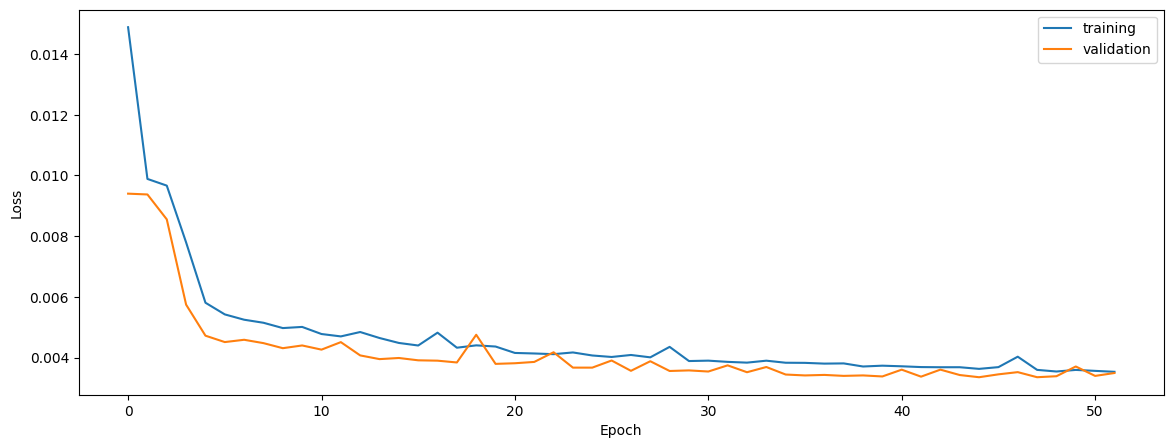

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8022003986245606
0.8024798042285217
0.7740082001885707


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8022003986245606
0.8024798042285217
0.7740082001885707


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.8059958104626772
0.8052216044677116
0.7836037802849801


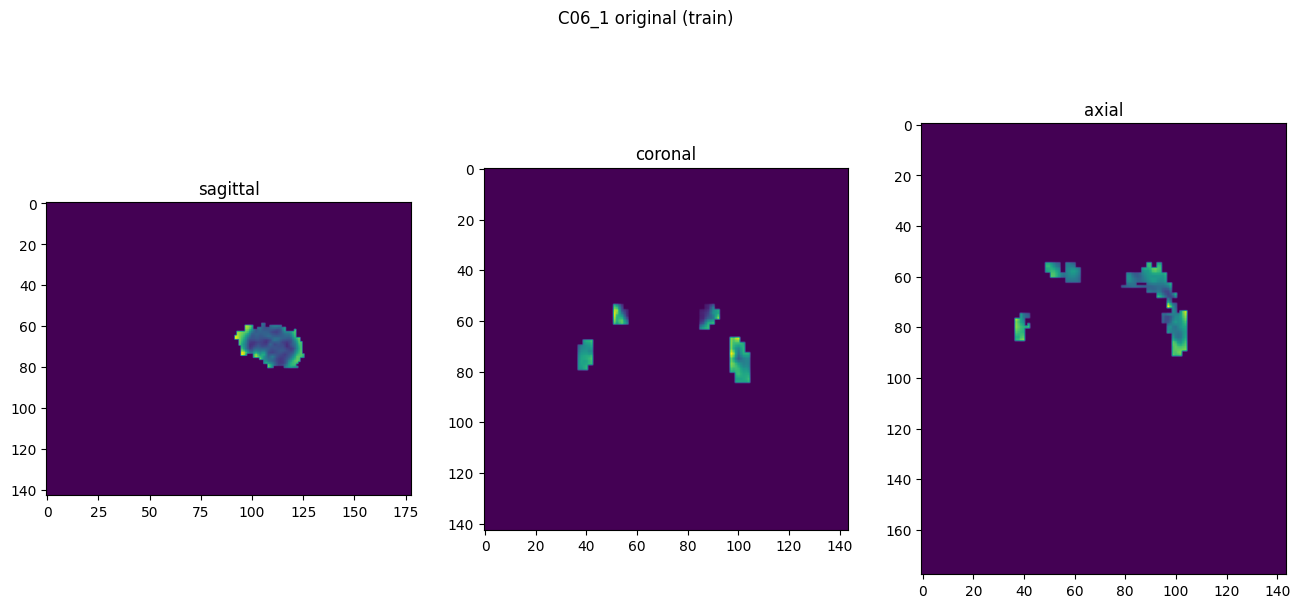

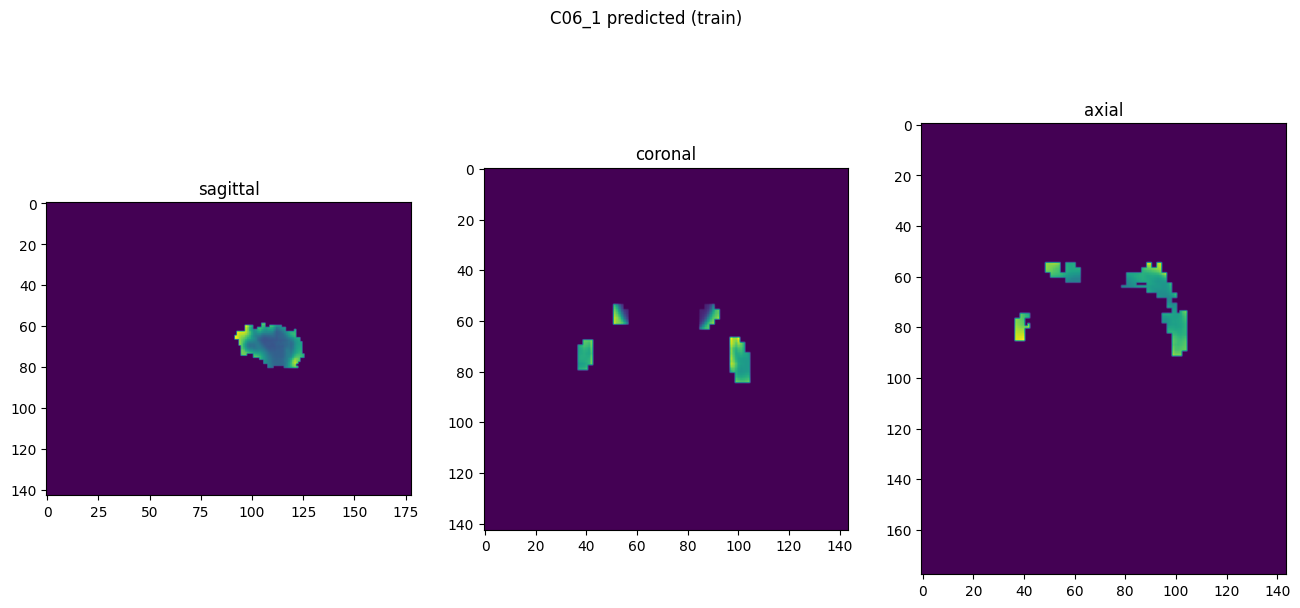

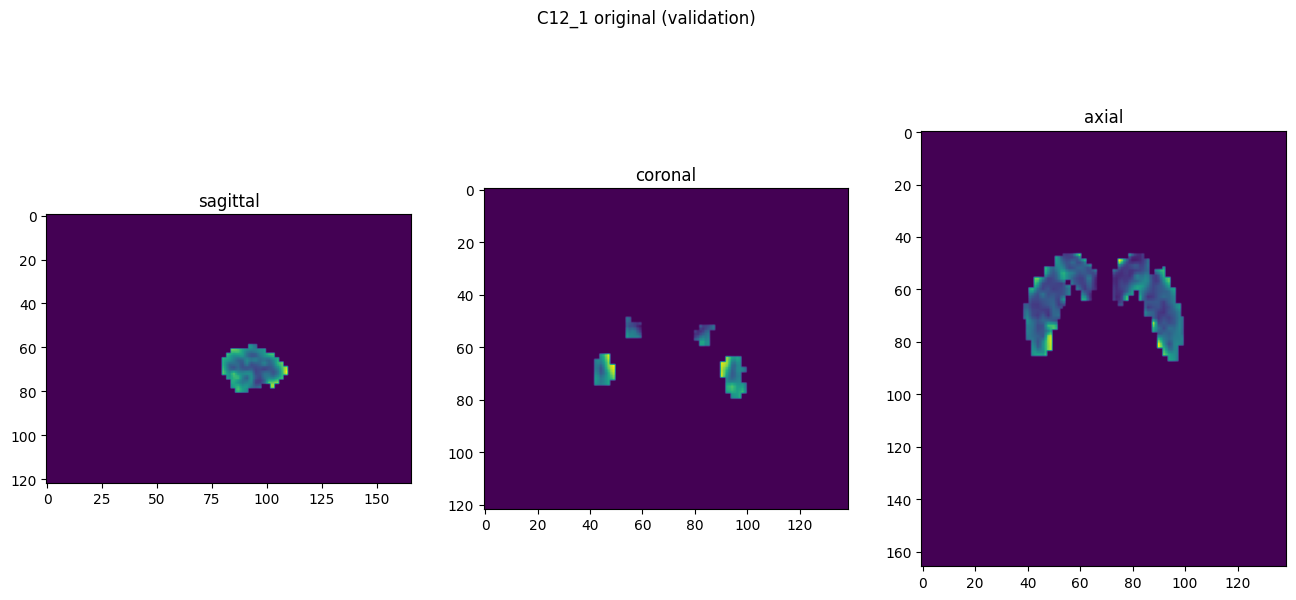

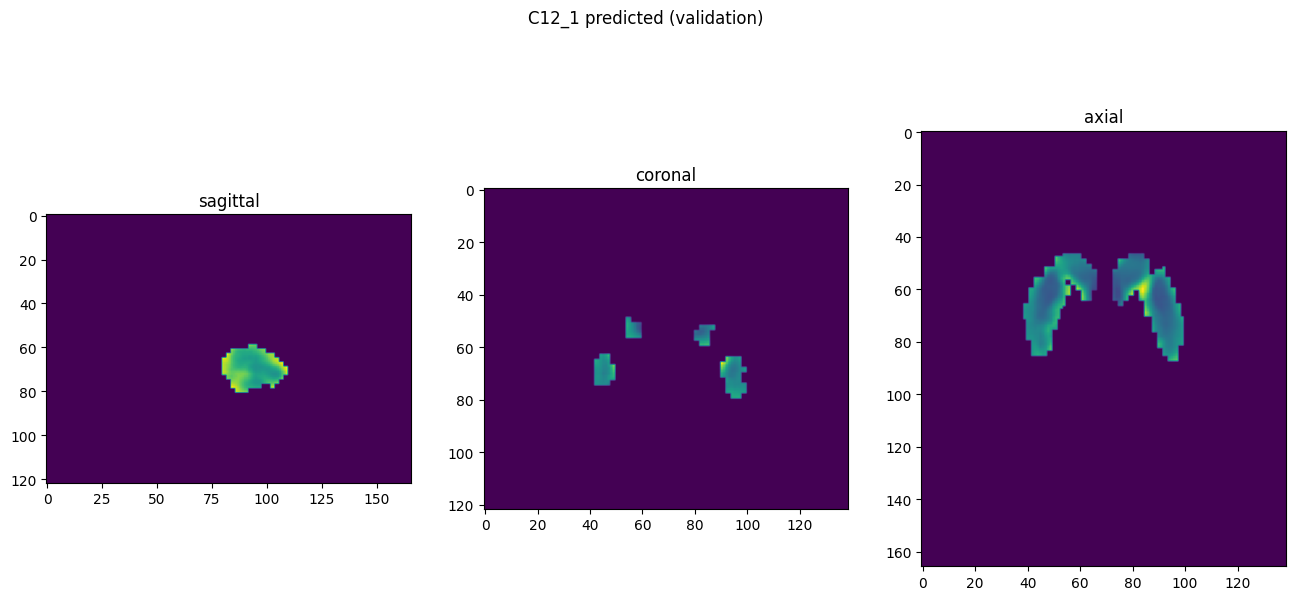

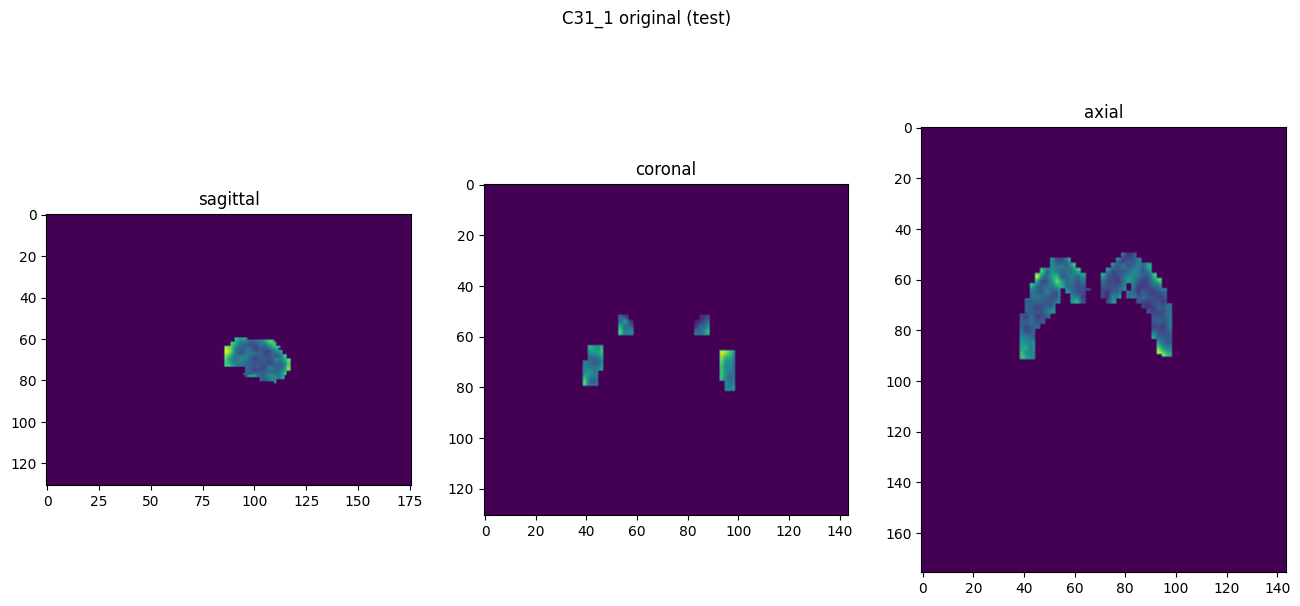

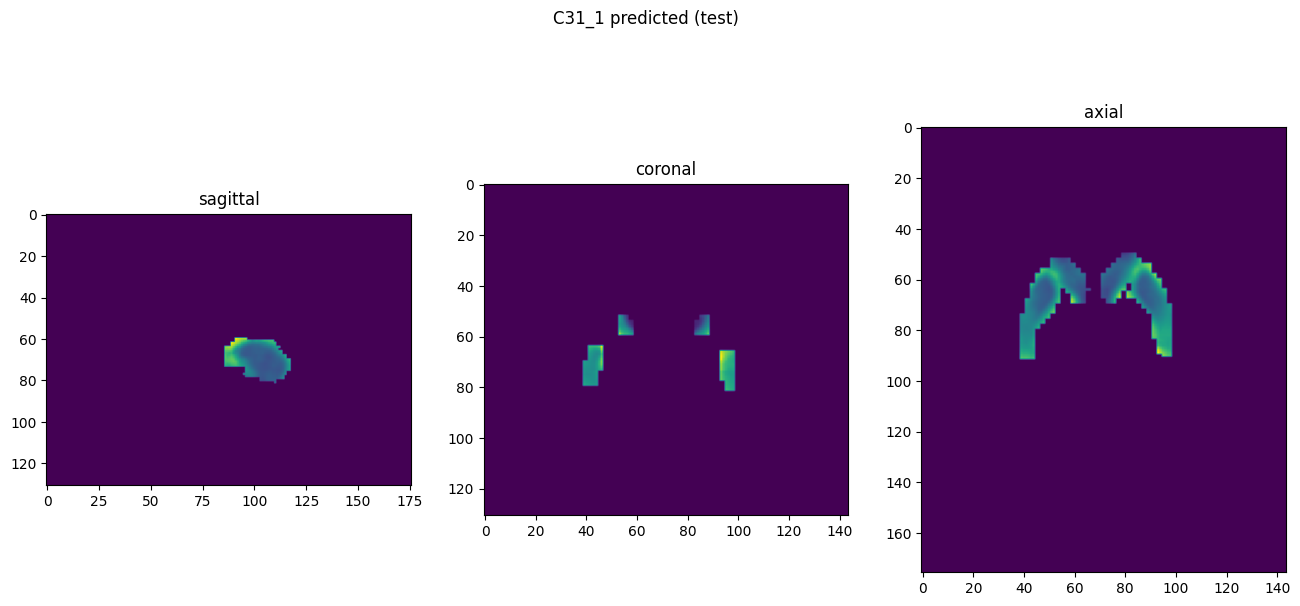

In [10]:
showResults(model, gen, threshold=None, background=False)